In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 11.2 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import shap


from google.colab import drive
colab = True
drive.mount('/content/drive')
data_path = '/content/drive/Shared drives/MSD 23 Drive/Datasets'

print('Data path: ', data_path)

Mounted at /content/drive
Data path:  /content/drive/Shared drives/MSD 23 Drive/Datasets


In [3]:
os.chdir(data_path)
df = pd.read_csv('prevalence_facilities_cleaned.csv')

In [4]:
# Remove all years after 2019 - missing values
df = df[df['year'] < 2020]
# drop OUDRATE column - only contains values for specific year
df = df.drop(columns = ['OUDRATE'])

In [5]:
# Check overall number of NaNs now
df.isna().sum().sum()

0

In [6]:
# features to use as predictors
cont_cols = ['ASSESSMENT', 
             'TESTING', 
             'TRANSITION', 
             'ANCILLARY', 
             'OTHER_SRVC']

binar_cols = ['DETOX',  
              'TREATMT',  
              'HOSPITAL',  
              'SRVC75',  
              'SRVC71',  
              'SRVC108',  
              'SRVC85',  
              'SRVC87',  
              'SRVC86',  
              'OTP',  
              'OPIOIDMAINT',
              'OPIOIDWDRAW',  
              'OPIOIDDETOX',  
              'OPIOIDNAL',  
              'DUI_DWI',  
              'ONLYDUI',  
              'SIGNLANG',  
              'SRVC30',  
              'SRVC34',  
              'SRVC33',  
              'SRVC64',  
              'SRVC63',
              'SRVC62',  
              'SRVC113',  
              'SRVC114',  
              'SRVC115',  
              'SRVC61',  
              'SRVC31',  
              'SRVC32',  
              'SRVC116',  
              'CTYPE4',  
              'CTYPE7',  
              'CTYPERC1',  
              'CTYPERC3', 
              'CTYPERC4',  
              'CTYPE1',  
              'CTYPE6',  
              'CTYPEML',  
              'CTYPEOP',  
              'CTYPE2',  
              'CTYPE3', 
              'FEESCALE',  
              'PAYASST',  
              'EARMARK',
              'REVCHK3',  
              'REVCHK1',  
              'REVCHK8',  
              'REVCHK5',  
              'REVCHK10',  
              'REVCHK15',  
              'REVCHK2',  
              'REVCHK17', 
              'LOC5',  
              'LICEN',  
              'ACCRED',  
              'OWNERSHP_Federal Government',  
              'OWNERSHP_Local, county or community government', 
              'OWNERSHP_Private non-profit organization',     
              'OWNERSHP_Private-for-profit organization',  
              'OWNERSHP_State government',  
              'OWNERSHP_Tribal Government']

features = cont_cols + binar_cols + ['facility_density']

In [7]:
df = df.reset_index().drop(columns = 'index')

In [8]:
##Sergio's cell, just saving the features and feature importance to make a figure. 
FI_list = []

In [9]:
X = df[features]
print(len(X.columns))

67


In [10]:
y_targets = [df[NEED] for NEED in ['NEED1', 'NEED2', 'NEED3']] 

Training model to predict target variable:  NEED1
Cross-validated negative root mean squared error score:  0.0033737764874603934
Evaluation on held-out test-set:  0.004413727904364335


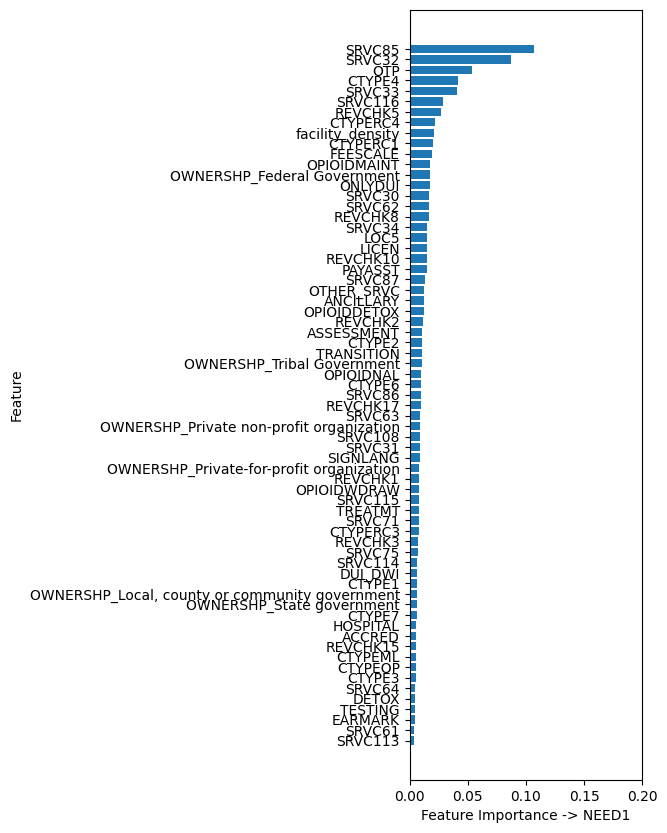

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


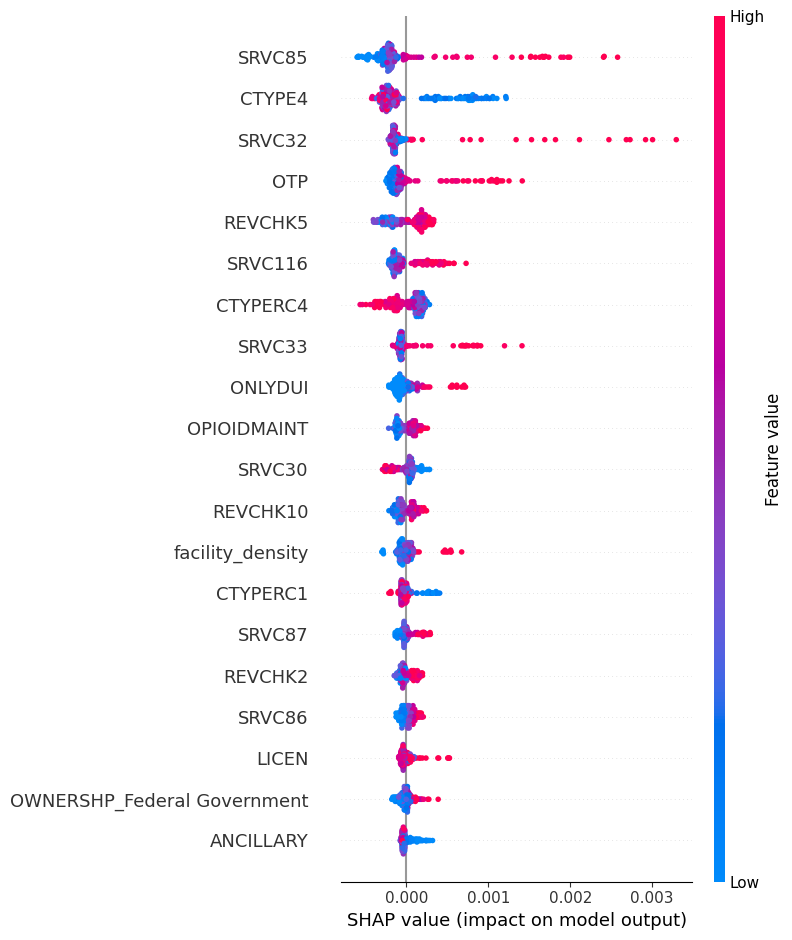

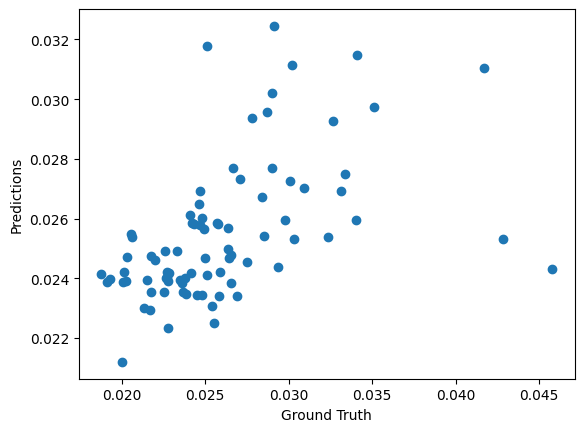

Training model to predict target variable:  NEED2
Cross-validated negative root mean squared error score:  0.006195573029569013
Evaluation on held-out test-set:  0.00646119333429787


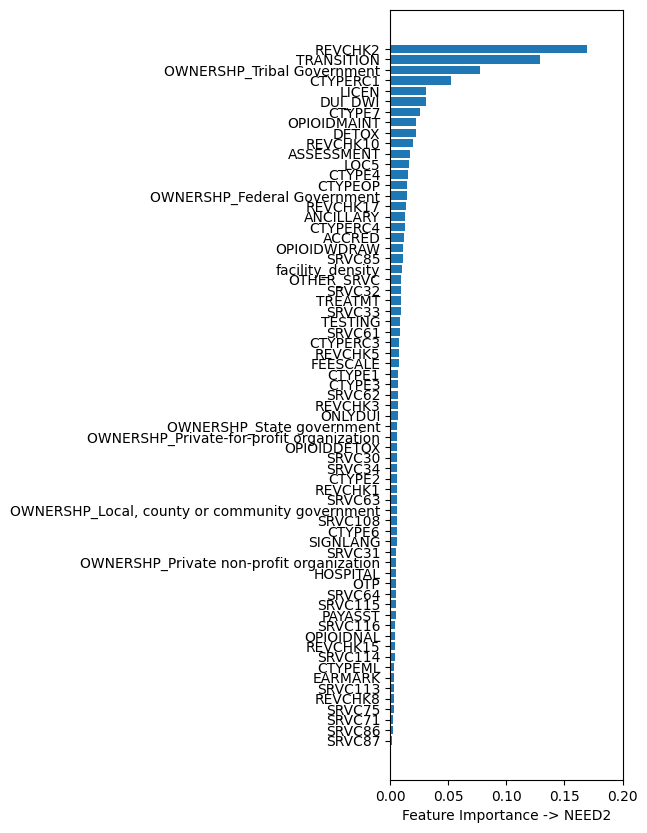

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


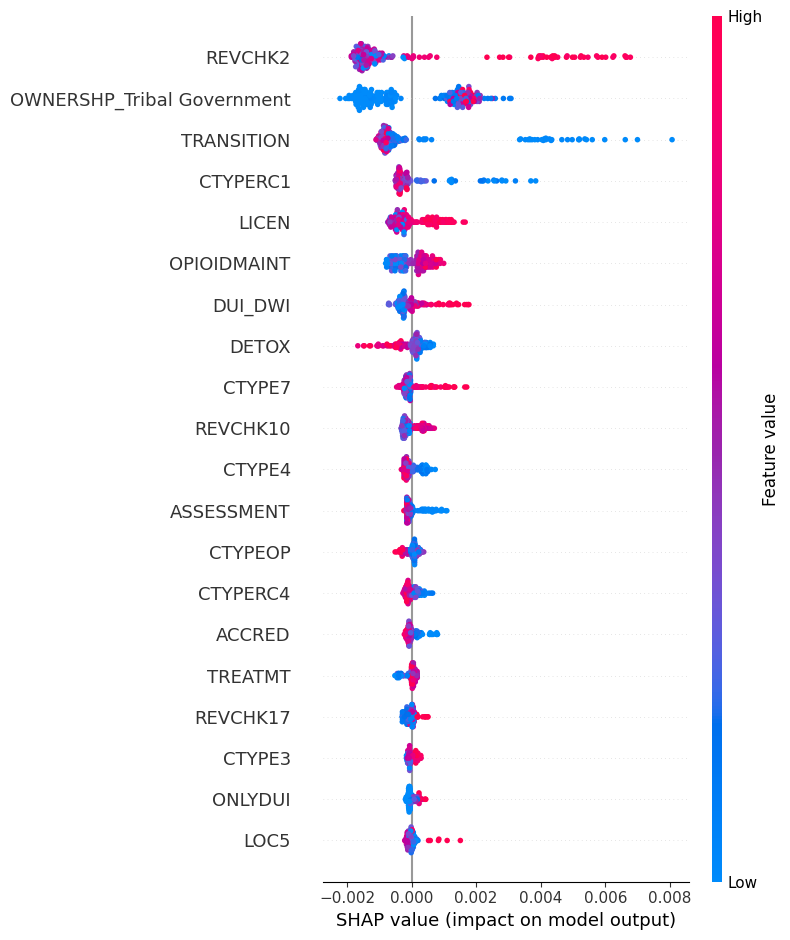

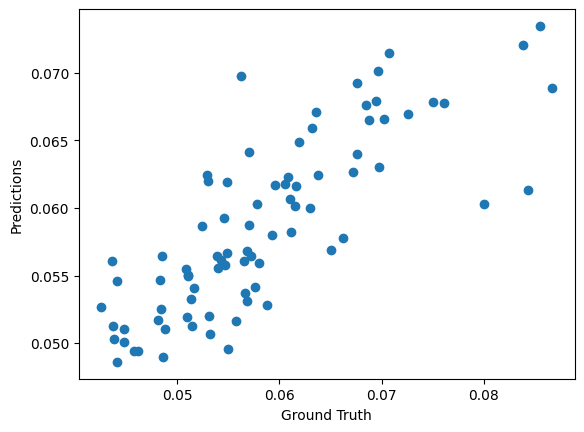

Training model to predict target variable:  NEED3
Cross-validated negative root mean squared error score:  0.007413732486565578
Evaluation on held-out test-set:  0.009085870612836899


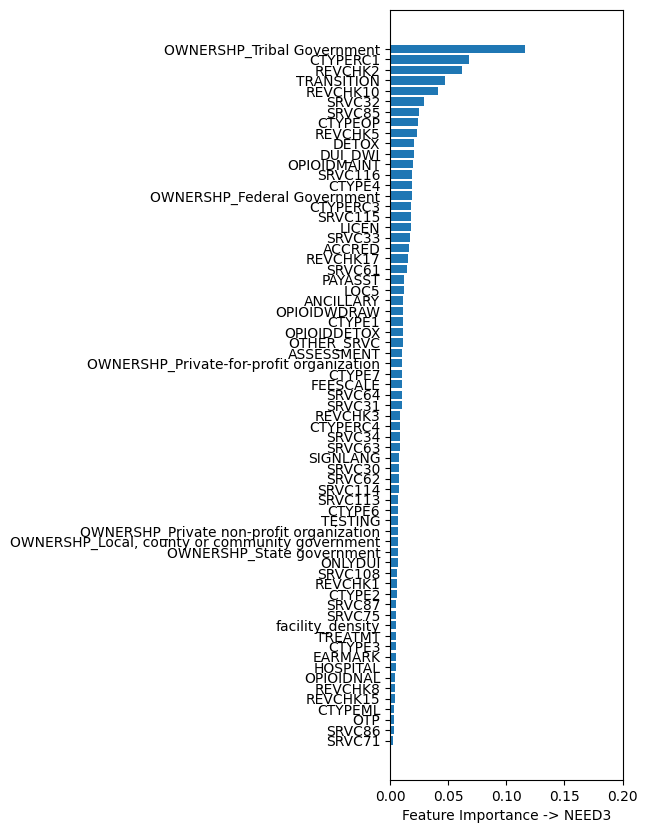

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


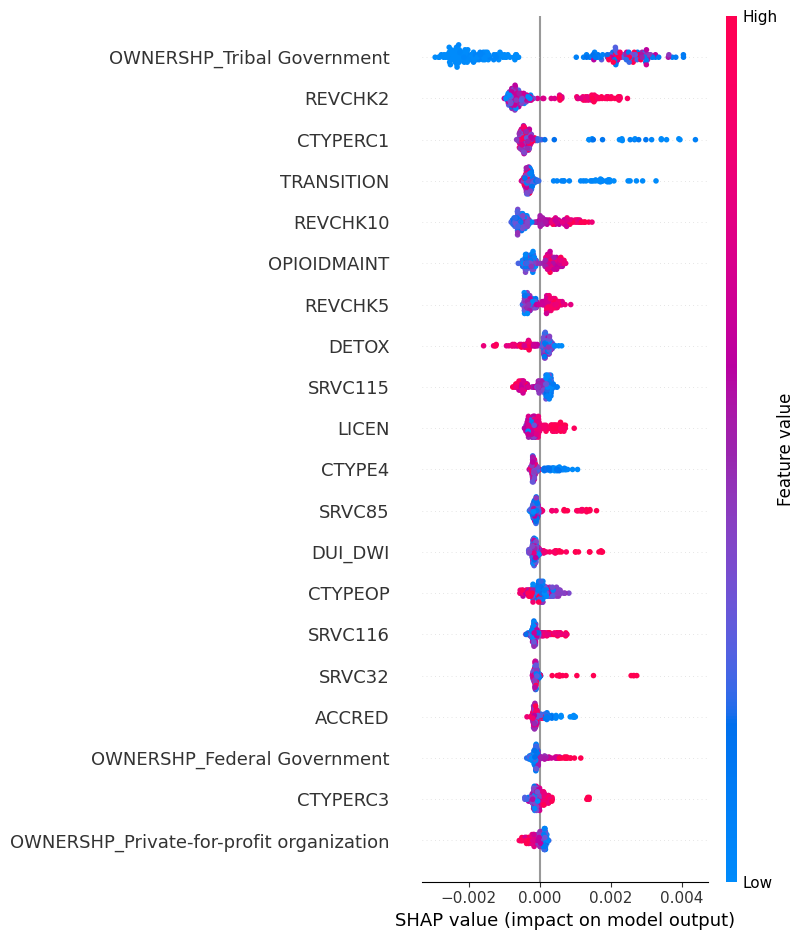

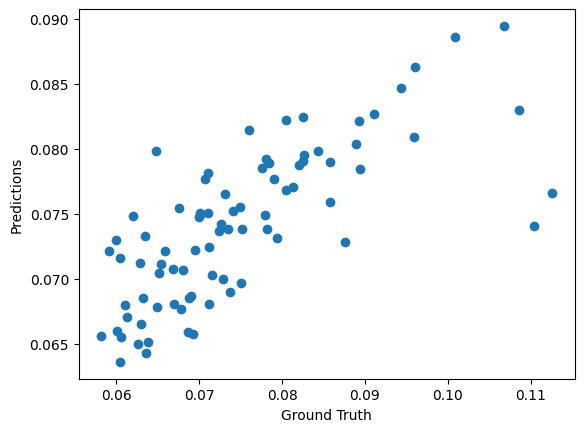

In [11]:
for target_label, index in zip(['NEED1', 'NEED2', 'NEED3'], range(3)):
    print('Training model to predict target variable: ', target_label)
    # Fetch target from df
    y = df[target_label]
    # train-test split - test is 25% of overall dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, random_state=0)
    # Instantiate random forest regressor
    rf = RandomForestRegressor(n_estimators=200,random_state=0)
    # Use 10-fold cross-val to get estimate of training RMSE
    score = cross_val_score(rf,
                            X_train,
                            y_train,
                            cv=10,
                            scoring='neg_mean_squared_error')
    print("Cross-validated negative root mean squared error score: ", np.sqrt(-score.mean()))
    # Fit the actual regressor
    rf.fit(X_train, y_train)
    # predict X_test
    y_pred = rf.predict(X_test)
    # get test set RMSE
    print('Evaluation on held-out test-set: ', np.sqrt(mean_squared_error(y_test, y_pred)))
    
    
    
    sorted_indices = rf.feature_importances_.argsort()    
    #Sergio: storing feature importance.
    FI_list.append([features[index] for index in sorted_indices])
    FI_list.append(rf.feature_importances_[sorted_indices])
    
    plt.figure(figsize = (3, 10))

    plt.barh([features[index] for index in sorted_indices], rf.feature_importances_[sorted_indices])
    #plt.bar(features, rf.feature_importances_)
    if index == 0: 
        plt.ylabel('Feature') 
    plt.xlabel('Feature Importance -> ' + target_label)
    plt.xlim([0, 0.2])
    #plt.yticks(rotation = 90); 
    plt.show()
    
    # Get SHAP values from rf model
    explainer = shap.Explainer(rf)
    # Explain model
    shap_values = explainer(X)
    # Beeswarm plot - SHAP values
    shap.summary_plot(shap_values, X)
    
    # Plot y_pred vs y_test
    plt.scatter(y_test, y_pred)
    plt.ylabel('Predictions')
    plt.xlabel('Ground Truth')
    plt.show()

In [12]:
# % RMSE of model trained to predict NEED1 compared to mean value of NEED1
100 * 0.003742526054387018 / df['NEED1'].mean()

14.618777423573334

In [13]:
# % RMSE of model trained to predict NEED2 compared to mean value of NEED2
100 * 0.006058487902000461 / df['NEED2'].mean()

10.37456968373836

In [14]:
# % RMSE of model trained to predict NEED3 compared to mean value of NEED3
100 * 0.008310847289104877 / df['NEED3'].mean()

11.150305793308661

In [16]:
#Sergio's cell
FI_need_df = pd.DataFrame(FI_list).transpose()
FI_need_df.columns = ['Features NEED1', 'Importance NEED1','Features NEED2', 'Importance NEED2', 'Features NEED3', 'Importance NEED3']
FI_need_df.to_csv('need_feature_importance.csv', index=False)

